In [1]:
import requests
import csv
import numpy as np
import nengo
import pandas as pd
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Basic Properties

In [2]:
monkey = "MM_S1"
datafile_path = r"..\\..\\Data Extraction\\"+monkey+"_raw.csv"

## Getting Functional Decoders

In [10]:
def functional_decoder(file_path, test_size):
    # Load in and normalize data
    data_df = pd.read_csv(file_path)

    # Get data information
    headers = data_df.columns.tolist()
    n_neurons = sum("Neuron" in string for string in headers)
    n_kinem = 4

    # Train-test split
    train_df, test_df = train_test_split(data_df, test_size=0.4, shuffle=False)
    
    # Removing Outliers
    for x in ['x_velocity', 'y_velocity', 'x_acceleration', 'y_acceleration']:
        mean = train_df[x].mean()
        std = train_df[x].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        train_df = train_df[(train_df[x] >= lower_bound) & (train_df[x] <= upper_bound)]

    # Set up matrices for the decoder (training)
    activity_matrix = train_df.loc[:, 'Neuron1':f'Neuron{n_neurons}']
    tranposed_activity_matrix = activity_matrix.transpose()
    kinem_matrix = train_df.loc[:, 'x_velocity':'y_acceleration']
    tranposed_kinem_matrix = kinem_matrix.transpose()
    A = tranposed_activity_matrix.to_numpy()  # n_neurons x n_timepoints
    Y = tranposed_kinem_matrix.to_numpy()    # n_kinematics x n_timepoints

    # Normalization
    scaled = np.max(np.abs(Y))
    print(scaled)
    Y = Y / scaled
    print(np.max(Y))
    
    # Compute decoders
    D = np.linalg.lstsq(A @ A.T, A @ Y.T, rcond=None)[0].T
    D_reg = np.linalg.lstsq(A @ A.T + A.shape[1] * np.square(np.random.normal(0, 0.001, 1)) * np.eye(n_neurons), A @ Y.T, rcond=None)[0].T

    # Set up matrices for the decoder (testing)
    test_activity_matrix = test_df.loc[:, 'Neuron1':f'Neuron{n_neurons}']
    test_tranposed_activity_matrix = test_activity_matrix.transpose()
    test_kinem_matrix = test_df.loc[:, 'x_velocity':'y_acceleration']
    test_tranposed_kinem_matrix = test_kinem_matrix.transpose()

    A_test = test_tranposed_activity_matrix.to_numpy()  # n_neurons x n_timepoints
    Y_test = test_tranposed_kinem_matrix.to_numpy()     # n_kinematics x n_timepoints

    # Predictions for testing data
    Y_hat_test = D @ A_test
    Y_hat_reg_test = D_reg @ A_test

    # Function to calculate errors
    def GetErrors(Y_, Y_HAT):
        Y_ = Y_ / scaled
        x_velocity_rmse = np.sqrt(np.square(np.subtract(Y_[0], Y_HAT[0])).mean())
        y_velocity_rmse = np.sqrt(np.square(np.subtract(Y_[1], Y_HAT[1])).mean())
        x_acceleration_rmse = np.sqrt(np.square(np.subtract(Y_[2], Y_HAT[2])).mean())
        y_acceleration_rmse = np.sqrt(np.square(np.subtract(Y_[3], Y_HAT[3])).mean())
        return x_velocity_rmse, y_velocity_rmse, x_acceleration_rmse, y_acceleration_rmse

    # Verifying Functional Decoder

    functional_error_test = GetErrors(Y_test, Y_hat_test)
    print("Functional Decoder Errors (Testing):")
    print(f"X Velocity RMSE: {functional_error_test[0]}")
    print(f"Y Velocity RMSE: {functional_error_test[1]}")
    print(f"X Acceleration RMSE: {functional_error_test[2]}")
    print(f"Y Acceleration RMSE: {functional_error_test[3]}")

    l2_error_test = GetErrors(Y_test, Y_hat_reg_test)
    print("L2 Regression Errors (Testing):")
    print(f"X Velocity RMSE: {l2_error_test[0]}")
    print(f"Y Velocity RMSE: {l2_error_test[1]}")
    print(f"X Acceleration RMSE: {l2_error_test[2]}")
    print(f"Y Acceleration RMSE: {l2_error_test[3]}")

    return (D, D_reg, A_test, Y_test, scaled)

In [11]:
decoder, decoder_reg, test_spikes, test_kinematic, scale_factor = functional_decoder(datafile_path, 0.4)

149.585676733118
0.9965639652517934
Functional Decoder Errors (Testing):
X Velocity RMSE: 0.03695240825554875
Y Velocity RMSE: 0.03698686254273597
X Acceleration RMSE: 0.29052567888184755
Y Acceleration RMSE: 0.32202730277131575
L2 Regression Errors (Testing):
X Velocity RMSE: 0.0369523988325139
Y Velocity RMSE: 0.03698686442208014
X Acceleration RMSE: 0.29052560328675014
Y Acceleration RMSE: 0.32202720208773


## Quick Stats

In [12]:
spikes = test_spikes
dt = 0.001
dti = 1/dt
spikes = spikes*dti

## Nengo Model

Build finished in 0:00:05.                                                      
Simulation finished in 0:00:04.                                                 


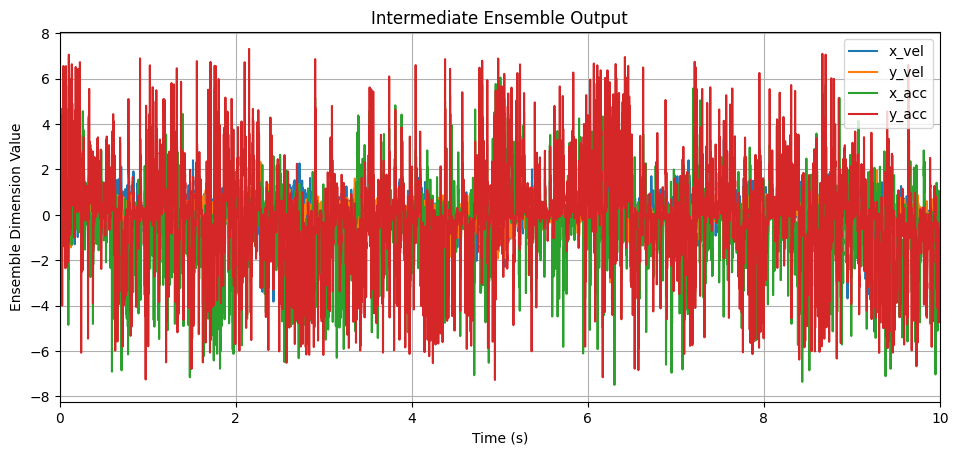

In [13]:
# Nengo Network Using Recorded Spikes as Input
np.random.seed(0)
with nengo.Network() as model:
    input_node = Node(lambda t: spikes[:,int(t / dt) - 1])
    ensemble = Ensemble(n_neurons=5000, dimensions=4, radius = 2)
    connector = Connection(input_node, ensemble, transform=decoder_reg)
    p_post = nengo.Probe(ensemble) # A probe enables us to assess the simulation data for a specific model component

with nengo.Simulator(model, dt=dt, seed=0) as sim:
    sim.run(10)

fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_post])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_vel", "y_vel", "x_acc", "y_acc"])
pl.grid()

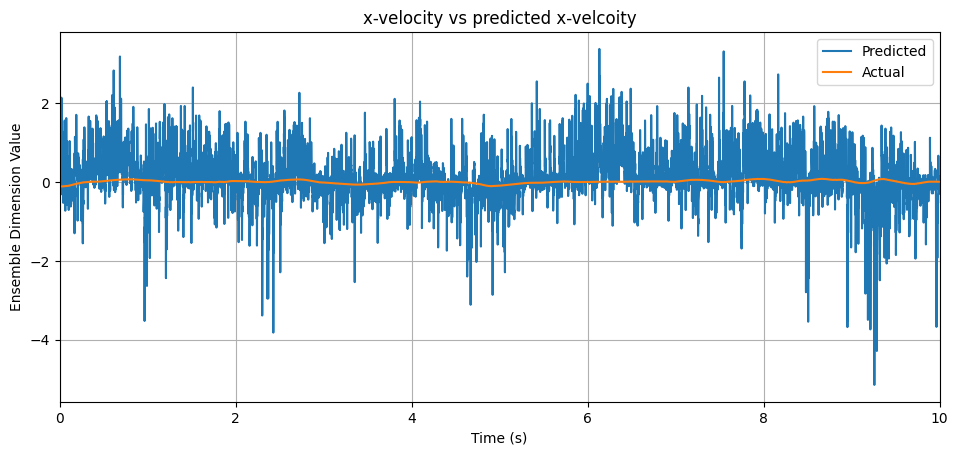

In [14]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_post][:, 0])
pl.plot(sim.trange(), test_kinematic[0,0:len(sim.trange())]/scale_factor)
pl.set_title("x-velocity vs predicted x-velcoity")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Predicted", "Actual"])
pl.grid()